In [5]:
!pip install pandas



[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [6]:
!pip install scikit-learn


[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [7]:
import pandas as pd

In [8]:
train_df = pd.read_csv('Training_set.csv')
test_df = pd.read_csv('Testing_set.csv')

In [9]:
train_df.head()

,filename,label
0,Image_1.jpg,SOUTHERN DOGFACE
1,Image_2.jpg,ADONIS
2,Image_3.jpg,BROWN SIPROETA
3,Image_4.jpg,MONARCH
4,Image_5.jpg,GREEN CELLED CATTLEHEART


In [10]:
train_df['filepath']= train_df['filename'].apply(lambda x: 'train/'+x)
test_df['filepath']= test_df['filename'].apply(lambda x: 'test/'+x)


In [11]:
train_df.head()

,filename,label,filepath
0,Image_1.jpg,SOUTHERN DOGFACE,train/Image_1.jpg
1,Image_2.jpg,ADONIS,train/Image_2.jpg
2,Image_3.jpg,BROWN SIPROETA,train/Image_3.jpg
3,Image_4.jpg,MONARCH,train/Image_4.jpg
4,Image_5.jpg,GREEN CELLED CATTLEHEART,train/Image_5.jpg


In [9]:
test_df.head()

,filename,filepath
0,Image_1.jpg,test/Image_1.jpg
1,Image_2.jpg,test/Image_2.jpg
2,Image_3.jpg,test/Image_3.jpg
3,Image_4.jpg,test/Image_4.jpg
4,Image_5.jpg,test/Image_5.jpg


In [12]:
from sklearn.model_selection import train_test_split

train_data, val_data = train_test_split(train_df, test_size=0.2, random_state=42, stratify=train_df['label'])
print(f"Training data shape: {train_data.shape}")
print(f"Validation data shape: {val_data.shape}")

Training data shape: (5199, 3)
Validation data shape: (1300, 3)


In [13]:
!pip install tensorflow


[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [14]:
!pip install numpy
!pip install matplotlib
!pip install seaborn


[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [15]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


In [16]:
img_width = 180
img_height = 180

In [17]:
# For training images
train_df['filepath'] = train_df['filename'].apply(lambda x: 'train/' + x)

# Split test set for validation
val_df = test_df.sample(frac=0.2, random_state=42)  # 20% of test as validation
test_df = test_df.drop(val_df.index)

# Add filepaths for validation and remaining test
val_df['filepath'] = val_df['filename'].apply(lambda x: 'test/' + x)
test_df['filepath'] = test_df['filename'].apply(lambda x: 'test/' + x)


    

In [18]:
class_names = sorted(train_df['label'].unique())
label_to_index = {name: i for i, name in enumerate(class_names)}

train_data['label_idx'] = train_data['label'].map(label_to_index)
val_data['label_idx']   = val_data['label'].map(label_to_index)


In [19]:
val_df.head()

,filename,filepath
2078,Image_2079.jpg,test/Image_2079.jpg
2770,Image_2771.jpg,test/Image_2771.jpg
1465,Image_1466.jpg,test/Image_1466.jpg
2089,Image_2090.jpg,test/Image_2090.jpg
2118,Image_2119.jpg,test/Image_2119.jpg


In [32]:
test_df.head()

,filename,filepath
0,Image_1.jpg,test/Image_1.jpg
1,Image_2.jpg,test/Image_2.jpg
2,Image_3.jpg,test/Image_3.jpg
3,Image_4.jpg,test/Image_4.jpg
4,Image_5.jpg,test/Image_5.jpg


In [30]:
train_df.head()

,filename,label,filepath,label_idx
0,Image_1.jpg,SOUTHERN DOGFACE,train/Image_1.jpg,66
1,Image_2.jpg,ADONIS,train/Image_2.jpg,0
2,Image_3.jpg,BROWN SIPROETA,train/Image_3.jpg,12
3,Image_4.jpg,MONARCH,train/Image_4.jpg,44
4,Image_5.jpg,GREEN CELLED CATTLEHEART,train/Image_5.jpg,33


In [20]:
import tensorflow as tf

def create_dataset(df, batch_size=32, shuffle=False):
    paths = df['filepath'].values
    labels = df['label_idx'].values

    ds = tf.data.Dataset.from_tensor_slices((paths, labels))

    def process_image(file_path, label):
        img = tf.io.read_file(file_path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, [img_height, img_width])
        img = img / 255.0
        return img, label

    ds = ds.map(process_image, num_parallel_calls=tf.data.AUTOTUNE)
    if shuffle:
        ds = ds.shuffle(1000)
    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds

train_ds = create_dataset(train_data, shuffle=True)
val_ds   = create_dataset(val_data)


In [35]:
val_df.head()

,filename,filepath
2078,Image_2079.jpg,test/Image_2079.jpg
2770,Image_2771.jpg,test/Image_2771.jpg
1465,Image_1466.jpg,test/Image_1466.jpg
2089,Image_2090.jpg,test/Image_2090.jpg
2118,Image_2119.jpg,test/Image_2119.jpg


In [35]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Mild augmentation for butterflies
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,        # small rotations for wing angles
    horizontal_flip=True,     # butterflies often symmetric
    brightness_range=[0.9,1.1],
    zoom_range=0.1,
    validation_split=0.2      # reserve 20% for validation
)

# Train generator
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col="filepath",
    y_col="label",
    target_size=(224,224),   # MobileNetV2 default
    batch_size=32,
    class_mode="sparse",
    subset="training",
    shuffle=True
)

# Validation generator
val_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col="filepath",
    y_col="label",
    target_size=(224,224),
    batch_size=32,
    class_mode="sparse",
    subset="validation",
    shuffle=False
)


Found 5200 validated image filenames belonging to 75 classes.
Found 1299 validated image filenames belonging to 75 classes.


In [36]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models, optimizers

num_classes = len(train_generator.class_indices)

# Load pretrained MobileNetV2 without top
base_model = MobileNetV2(input_shape=(224,224,3), include_top=False, weights='imagenet')
base_model.trainable = False  # Freeze base

# Build top classifier
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 75)             │        19,275 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,605,195 (9.94 MB)

 Trainable params: 347,211 (1.32 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [37]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=15  # should reach ~70% in first few epochs
)

# Save trained model
model.save("butterfly_mobilenetv2.h5")

# Save class names for Streamlit app
import pickle
with open("class_names.pkl", "wb") as f:
    pickle.dump(list(train_generator.class_indices.keys()), f)


c:\Users\Aawazn\Downloads\archive (1)\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 234s 1s/step - accuracy: 0.0504 - loss: 4.2405 - val_accuracy: 0.1840 - val_loss: 3.7703
Epoch 2/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 213s 1s/step - accuracy: 0.1723 - loss: 3.5832 - val_accuracy: 0.4088 - val_loss: 3.0485
Epoch 3/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 204s 1s/step - accuracy: 0.2927 - loss: 2.9517 - val_accuracy: 0.5627 - val_loss: 2.3646
Epoch 4/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 205s 1s/step - accuracy: 0.4194 - loss: 2.4145 - val_accuracy: 0.6721 - val_loss: 1.8991
Epoch 5/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 202s 1s/step - accuracy: 0.4983 - loss: 2.0670 - val_accuracy: 0.7182 - val_loss: 1.5787
Epoch 6/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 241s 1s/step - accuracy: 0.5537 - loss: 1.7945 - val_accuracy: 0.7467 - val_loss: 1.3608
Epoch 7/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 254s 2s/step - accuracy: 0.5996 - loss: 1.5865 - val_accuracy: 0.7768 - val_loss: 1.1994
Epoch 8/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 249s 2s/step - accuracy: 0.6362 - loss: 1.4412 - val_accu

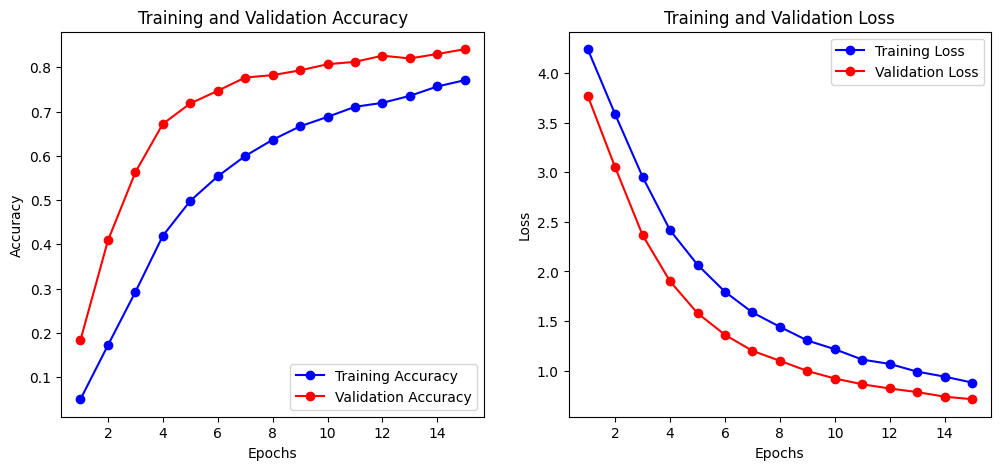

In [38]:
import matplotlib.pyplot as plt

# Assuming your history variable is from model.fit()
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

# Accuracy plot
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(epochs, acc, 'b-o', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r-o', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1,2,2)
plt.plot(epochs, loss, 'b-o', label='Training Loss')
plt.plot(epochs, val_loss, 'r-o', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


In [40]:
import os
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
import pickle
import pandas as pd

# Load trained model
model = load_model("butterfly_mobilenetv2.h5")

# Load class names
with open("class_names.pkl", "rb") as f:
    class_names = pickle.load(f)

# Function to preprocess a single image
def preprocess_img(img_path, target_size=(224,224)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)/255.0  # normalize
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

# Folder containing test images
test_folder = "test"

# Prepare list to store results
results = []

for fname in os.listdir(test_folder):
    if fname.lower().endswith(('.jpg','.jpeg','.png')):
        img_path = os.path.join(test_folder, fname)
        img_array = preprocess_img(img_path)
        pred = model.predict(img_array)
        top_idx = pred[0].argmax()
        results.append({"filename": fname, "predicted_label": class_names[top_idx]})

# Convert to DataFrame and save to CSV
results_df = pd.DataFrame(results)
results_df.to_csv("test_predictions.csv", index=False)

print("Predictions saved to test_predictions.csv")
print(results_df.head())


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━

In [41]:
pip install streamlit


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip
